# Genetic programming: symbolic regresion

In [1]:
%load_ext autoreload
%autoreload 2
import gp
import plotting as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import product
from random import seed
from math import sin, cos, pi, exp, sqrt, log
import time

In [38]:
# set of problems
problems = ({'func' : lambda x: exp(abs(x))*sin(x), 'interval' : np.array(list(product(np.linspace(-3,3,100)))), 'name' : 'e^|x|*sin(x)'},)
def generate_dataset(inputs, func):
    outputs = np.zeros_like(inputs[:, 0])
    for i, t in enumerate(inputs):
        outputs[i] = func(*t)
    return np.column_stack([inputs, np.vstack(outputs)])


In [444]:
# gp parameters
def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
def safe_div(x, y): return x / y if y != 0 else x
def safe_log(x): return log(max(1e-10, abs(x)))
def safe_exp(x): return exp(min(30, x))

BINARY_FUNCTIONS = (add, sub, mul, safe_div)
UNARY_FUNCTIONS = (abs, sin, cos, safe_exp, safe_log)
FUNC_NAMES = {add : '+', sub : '-', mul : '*', safe_div : '/', sin : 'sin', cos : 'cos', abs : 'abs', safe_exp : 'e^', safe_log : 'log'}
INPUTS = ('x',)
TERMINALS = (-1, 0, 1) + INPUTS


gp.Parameters.gp_rules = {
    'binary_functions' : BINARY_FUNCTIONS,
    'unary_functions' :  UNARY_FUNCTIONS,
    'func_names' :       FUNC_NAMES,
    'terminals' :        TERMINALS,
    'inputs' :           INPUTS,
    'node_data' : BINARY_FUNCTIONS + UNARY_FUNCTIONS + TERMINALS,
    'pop_size' :         128, # population size
    'min_depth' :        2, # minimal initial random tree depth
    'max_depth' :        4, # maximal initial random tree depth
    'generations' :      np.inf, # maximal number of generations to run evolution
    'tournament_size' :  3, # size of tournament for tournament selection
    'xo_rate' :          0.5, # crossover rate
    'prob_mutation' :    0.1, # per-node mutation probability
    'epsilon' :          0.1, # epsilon used to compute hit rate
    'evaluations_limit' : 1e6
}

In [445]:
runs = 5

## Using fitness predictor

execution time: 30.81442904472351
execution time: 61.135355949401855
execution time: 92.90131187438965
execution time: 119.5423629283905
execution time: 167.10157251358032


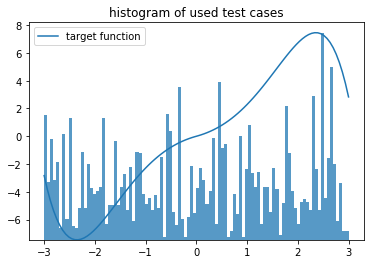

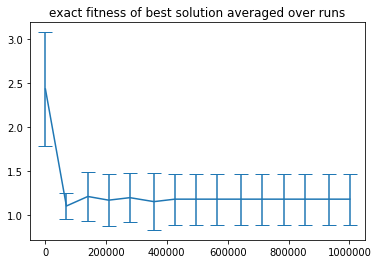

best solution of the run:


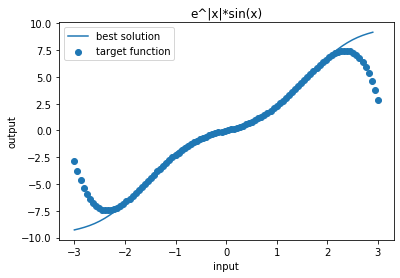

execution time: 172.09438824653625


In [446]:
# run gp on problems with parameters specified above
seed() # set seed here to reproduce same conditions
start = time.time()

for problem in problems:
    d = generate_dataset(problem['interval'], problem['func'])
    x = gp.GeneticProgram(d)
    fp_manager = gp.SLFitnessPredictorManager(x, d.shape[0])
    
    x_values = []
    used_predictors = []
    fitnesses = []
    best_ever_fitness = np.inf
    best_ever = None
    worse_solutions = []
    
    for i in range(runs):
        res = x.run_evolution(fp_manager=fp_manager, verbose=False)
        end = time.time()
        print(f'execution time: {end - start}')
        if res['best_of_run_exact_fitness'] < best_ever_fitness:
            best_ever_fitness = res['best_of_run_exact_fitness']
            best_ever = res['best']
    
        x_values.append(res['test_cases_evaluations'])
        used_predictors.append(res['used_predictors'])
        fitnesses.append(res['best_of_run_fitnesses'])
        worse_solutions.append(res['worse_solution'])
        
    
    # analyze situations where worse solution was prefered
    for i, sl in enumerate(worse_solutions):
        for j, s in enumerate(sl):
            # todo using res here doesnt make any sense at all and for this to work on multiple runs this has to be rewritten
            predictor_idx = np.where(x_values[i] == s)[0][0]
            plt.scatter(np.ones_like(used_predictors[i][0])*-1, used_predictors[i][predictor_idx - 1])
            plt.scatter(np.ones_like(used_predictors[i][0]), used_predictors[i][predictor_idx])
            plt.title(f'run: {i} change between {x_values[i][predictor_idx - 1]} -> {x_values[i][predictor_idx]}\n solution with {fitnesses[i][predictor_idx]} was prefered to {fitnesses[i][predictor_idx - 1]}')
            plt.savefig(f'{i}_{j}_0')
            plt.clf()
            plt.subplot(121)
            plt.title('previous')
            pl.target_with_predictor(d, res['best_solutions'][predictor_idx - 1],used_predictors[i][predictor_idx - 1])
            plt.subplot(122)
            plt.title('new')
            pl.target_with_predictor(d, res['best_solutions'][predictor_idx],used_predictors[i][predictor_idx])
            #print(x.fitness(res['best_solutions'][predictor_idx-1]), x.fitness(res['best_solutions'][predictor_idx]))
            
            plt.savefig(f'{i}_{j}_1')
            plt.clf()
    
    # select widest range
    x_values = x_values[np.argmax([len(v) for v in x_values])]
    
    # fill shorter runs with last values (in case some run converged or something...)
    for i in range(len(fitnesses)):
        while len(used_predictors[i]) < len(x_values): 
            used_predictors[i] = np.vstack([used_predictors[i], used_predictors[i][-1]])
        while len(fitnesses[i]) < len(x_values):
            fitnesses[i] = np.append(fitnesses[i], fitnesses[i][-1])
    
    # samples to use 
    idxs = np.linspace(0, len(x_values)-1, 15, dtype=np.int32)

    used_predictors = np.concatenate(used_predictors)
    

    #used_predictors = np.concatenate(used_predictors).flatten()
    used_predictors = d[:, 0][used_predictors.flatten()]
    fitnesses = np.vstack(fitnesses)
    
    # plot histogram
    vals, bins = np.histogram(used_predictors, bins=d.shape[0])
    # make bins same size as graph of the function
    vals = vals * ((max(d[:, 1]) - min(d[:, 1])) / max(vals))
    plt.bar(bins[:-1], vals, bottom=min(d[:, 1]), align='edge', alpha=0.75, width=(d[-1, 0]-d[0, 0]) / len(vals))
    plt.plot(d[:, 0], d[:, 1], label='target function')
    plt.title('histogram of used test cases')
    plt.legend()
    plt.show()
    

    #plot fitness
    avg_fitnesses = np.mean(fitnesses, axis=0)
    errors = np.std(fitnesses, axis=0)
    plt.errorbar(x_values[idxs], avg_fitnesses[idxs], yerr=errors[idxs], capsize=7)
    
    #for s in worse_solutions:
    #    for ss in s:
    #        plt.axvline(x=ss, ymin=0, ymax=max(avg_fitnesses), color='r', linestyle='dashed')
    plt.title('exact fitness of best solution averaged over runs')
    plt.show()

    print(f'best solution of the run:')
    pl.plot_solution_and_target(best_ever, problem['name'] , d)
    end = time.time()
    print(f'execution time: {end - start}')

## Using all test cases

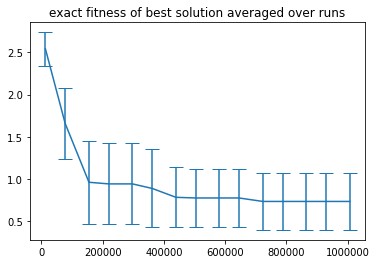

best solution of the run:


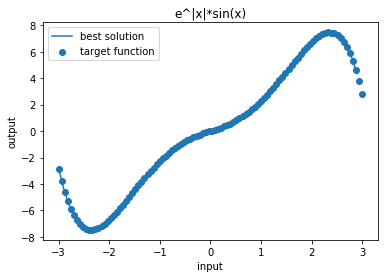

execution time: 32.32873177528381


In [447]:
# run gp on problems with parameters specified above
seed() # set seed here to reproduce same conditions
start = time.time()

for problem in problems:
    d = generate_dataset(problem['interval'], problem['func'])
    x = gp.GeneticProgram(d)
    
    x_values = []
    used_predictors = []
    fitnesses = []
    best_ever_fitness = np.inf
    best_ever = None
    worse_solutions = []
    
    for i in range(runs):
        res = x.run_evolution(fp_manager=None, verbose=False)
        if res['best_of_run_exact_fitness'] < best_ever_fitness:
            best_ever_fitness = res['best_of_run_exact_fitness']
            best_ever = res['best']
    
        x_values.append(res['test_cases_evaluations'])
        fitnesses.append(res['best_of_run_fitnesses'])

    
    # select widest range
    x_values = x_values[np.argmax([len(v) for v in x_values])]
    
    # fill shorter runs with last values (in case some run converged or something...)
    for i in range(len(fitnesses)):
        while len(fitnesses[i]) < len(x_values):
            fitnesses[i] = np.append(fitnesses[i], fitnesses[i][-1])
    
    # samples to use 
    idxs = np.linspace(0, len(x_values)-1, 15, dtype=np.int32)


    fitnesses = np.vstack(fitnesses)

    #plot fitness
    avg_fitnesses = np.mean(fitnesses, axis=0)
    errors = np.std(fitnesses, axis=0)
    plt.errorbar(x_values[idxs], avg_fitnesses[idxs], yerr=errors[idxs], capsize=7)
    
    #for s in worse_solutions:
    #    for ss in s:
    #        plt.axvline(x=ss, ymin=0, ymax=max(avg_fitnesses), color='r', linestyle='dashed')
    plt.title('exact fitness of best solution averaged over runs')
    plt.show()

    print(f'best solution of the run:')
    pl.plot_solution_and_target(best_ever, problem['name'] , d)
    end = time.time()
    print(f'execution time: {end - start}')